In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
import os

In [ ]:
od.download("https://www.kaggle.com/datasets/hngngn/portrait-segmentation-128x128/data")

In [ ]:
import os
import cv2
import numpy as np

IMAGE_DIR = '/content/portrait-segmentation-128x128/xtrain'
MASK_DIR = '/content/portrait-segmentation-128x128/ytrain'

def load_images(image_dir, mask_dir, img_size=(128, 128), max_images=2000):
    # Get all image paths
    image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])[:max_images]
    mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])[:max_images]

    images = []
    masks = []

    for img_path, mask_path in zip(image_paths, mask_paths):
        # Read images
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Check if the image and mask were loaded successfully
        if img is None:
            print(f"Warning: Could not load image {img_path}. Skipping.")
            continue
        if mask is None:
            print(f"Warning: Could not load mask {mask_path}. Skipping.")
            continue

        # Resize images and masks
        img = cv2.resize(img, img_size)
        mask = cv2.resize(mask, img_size)

        # Normalize images and masks
        img = img / 255.0
        mask = mask / 255.0

        images.append(img)
        masks.append(mask)

    images = np.array(images)
    masks = np.array(masks)

    # Expand the mask to have a single channel (required for U-Net)
    masks = np.expand_dims(masks, axis=-1)

    return images, masks  # Return images and masks

# Load a maximum of 8000 images
images, masks = load_images(IMAGE_DIR, MASK_DIR, max_images=8000)

# Output the shape of the datasets
print(f"Loaded {images.shape[0]} images and {masks.shape[0]} masks.")
print(f"Image shape: {images.shape[1:]}, Mask shape: {masks.shape[1:]}")

Loaded 8000 images and 8000 masks.
Image shape: (128, 128, 3), Mask shape: (128, 128, 1)


In [ ]:
# prompt: save the images and mask numpy

import numpy as np

# Assuming 'images' and 'masks' are your NumPy arrays
# from the previous code

np.save('images.npy', images)
np.save('masks.npy', masks)
# np.save('foregrounds.npy',foregrounds)

print("Images and masks saved as images.npy and masks.npy")

Images and masks saved as images.npy and masks.npy


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define U-Net without Attention
def unet(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)

    # Contracting path (Encoder)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    # Expansive path (Decoder)
    up5 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4)
    concat5 = layers.concatenate([up5, conv3], axis=3)
    conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(concat5)
    conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    concat6 = layers.concatenate([up6, conv2], axis=3)
    conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat6)
    conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat7 = layers.concatenate([up7, conv1], axis=3)
    conv7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat7)
    conv7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv7)

    model = models.Model(inputs=inputs, outputs=outputs)

    return model

# Initialize the U-Net model
model = unet(input_size=(128, 128, 3))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 256)    │        524,544 │ conv2d_7[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 512)    │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 256)    │      1,179,904 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 64, 64, 128)    │        131,200 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)    

 Total params: 7,697,345 (29.36 MB)

 Trainable params: 7,697,345 (29.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import numpy as np

# Load the NumPy arrays
images = np.load('images.npy')  # Load the uploaded images
masks = np.load('masks.npy')    # Load the uploaded masks

print("Images and masks loaded from local environment.")
print(f"Shape of images array: {images.shape}")
print(f"Shape of masks array: {masks.shape}")

Images and masks loaded from local environment.
Shape of images array: (8000, 128, 128, 3)
Shape of masks array: (8000, 128, 128, 1)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with EarlyStopping
history = model.fit(images, masks, batch_size=16, epochs=20, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 113s 212ms/step - accuracy: 0.7458 - loss: 0.5196 - val_accuracy: 0.8504 - val_loss: 0.3672
Epoch 2/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 101s 170ms/step - accuracy: 0.8855 - loss: 0.2773 - val_accuracy: 0.9083 - val_loss: 0.2277
Epoch 3/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 82s 169ms/step - accuracy: 0.9249 - loss: 0.1914 - val_accuracy: 0.9211 - val_loss: 0.2030
Epoch 4/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 82s 169ms/step - accuracy: 0.9440 - loss: 0.1435 - val_accuracy: 0.9321 - val_loss: 0.1745
Epoch 5/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 82s 169ms/step - accuracy: 0.9532 - loss: 0.1220 - val_accuracy: 0.9375 - val_loss: 0.1574
Epoch 6/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 82s 169ms/step - accuracy: 0.9593 - loss: 0.1064 - val_accuracy: 0.9412 - val_loss: 0.1554
Epoch 7/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 82s 169ms/step - accuracy: 0.9635 - loss: 0.0962 - val_accuracy: 0.9450 - val_loss: 0.1498
Epoch 8/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 82s 169ms/step - accuracy: 0.9675 - loss:

In [ ]:
# Save the trained model
model.save('/content/unet_background_removal.keras')

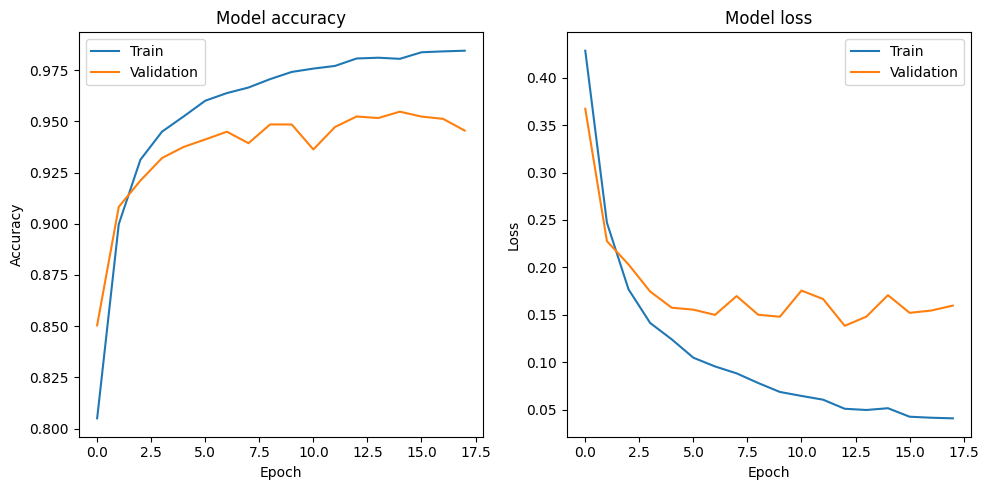

In [ ]:
# prompt: denerate  history plot
import matplotlib.pyplot as plt
# Plot training history
plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


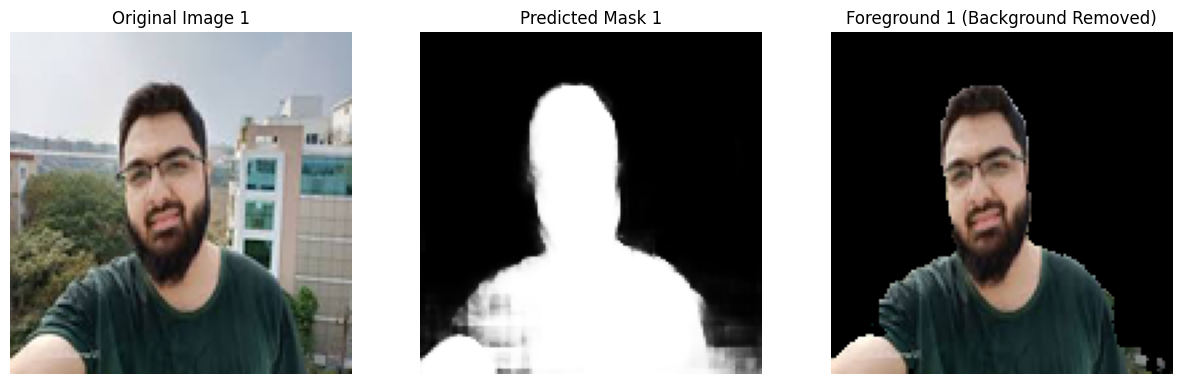

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


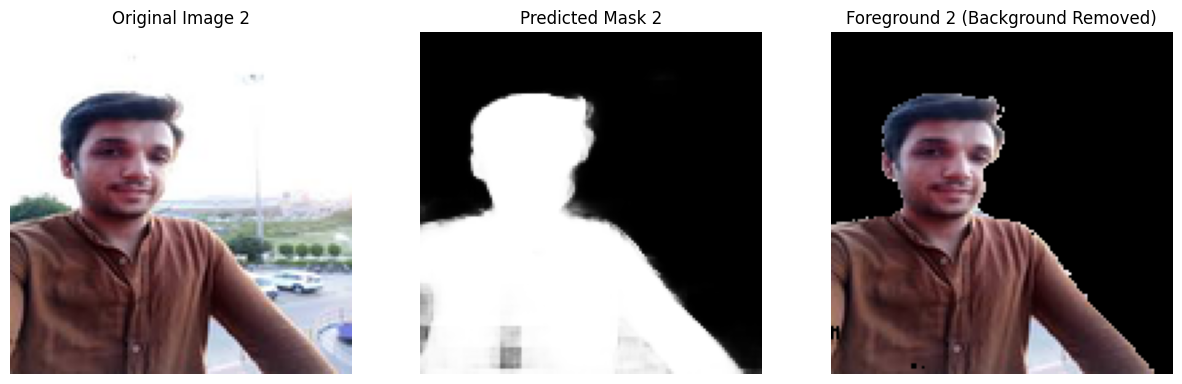

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


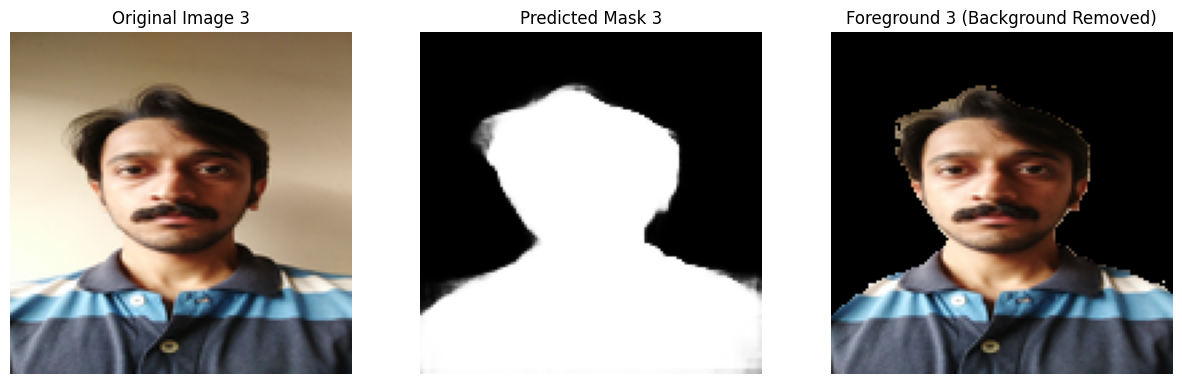

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


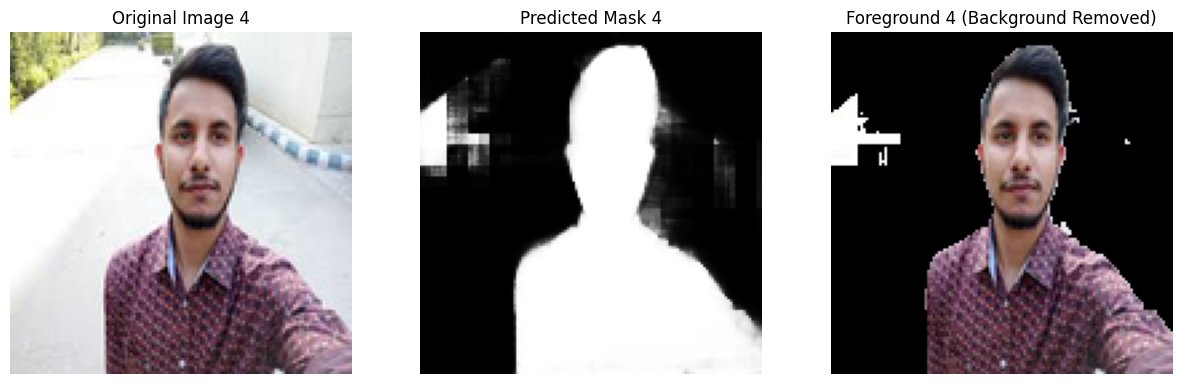

Processed images are saved in: /content/portrait-segmentation-128x128/output_images


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model('/content/unet_background_removal.keras')

# Directory containing test images
test_image_dir = '/content/portrait-segmentation-128x128/test_image'

# Directory to save the final images
output_dir = '/content/portrait-segmentation-128x128/output_images'
os.makedirs(output_dir, exist_ok=True)

# Get a list of test image files
test_image_files = [f for f in os.listdir(test_image_dir) if os.path.isfile(os.path.join(test_image_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Function to create a binary mask from the predicted mask
def create_binary_mask(predicted_mask, threshold=0.5):
    binary_mask = (predicted_mask > threshold).astype(np.uint8) * 255
    return binary_mask

# Loop through the test images and process them
for i, image_file in enumerate(test_image_files[:5]):  # Limit to first 5
    image_path = os.path.join(test_image_dir, image_file)

    try:
        # Load and preprocess the image
        test_image = cv2.imread(image_path)
        test_image_resized = cv2.resize(test_image, (128, 128)) / 255.0
        test_image_resized = np.expand_dims(test_image_resized, axis=0)

        # Predict the mask
        predicted_mask = model.predict(test_image_resized)
        predicted_mask = np.squeeze(predicted_mask, axis=0)

        # Create a binary mask
        binary_mask = create_binary_mask(predicted_mask)

        # Resize the binary mask to the original image size
        resized_binary_mask = cv2.resize(binary_mask, (test_image.shape[1], test_image.shape[0]))
        resized_binary_mask_3_channel = cv2.cvtColor(resized_binary_mask, cv2.COLOR_GRAY2BGR)

        # Apply the mask to the original image
        foreground = cv2.bitwise_and(test_image, resized_binary_mask_3_channel)

        # Save the final foreground image
        output_path = os.path.join(output_dir, f"foreground_{i+1}.png")
        cv2.imwrite(output_path, foreground)

        # Display the original image, mask, and final foreground
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
        plt.title(f"Original Image {i+1}")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(predicted_mask, cmap='gray')
        plt.title(f"Predicted Mask {i+1}")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB))
        plt.title(f"Foreground {i+1} (Background Removed)")
        plt.axis('off')

        plt.show()

    except Exception as e:
        print(f"Error processing image {image_file}: {e}")

print(f"Processed images are saved in: {output_dir}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


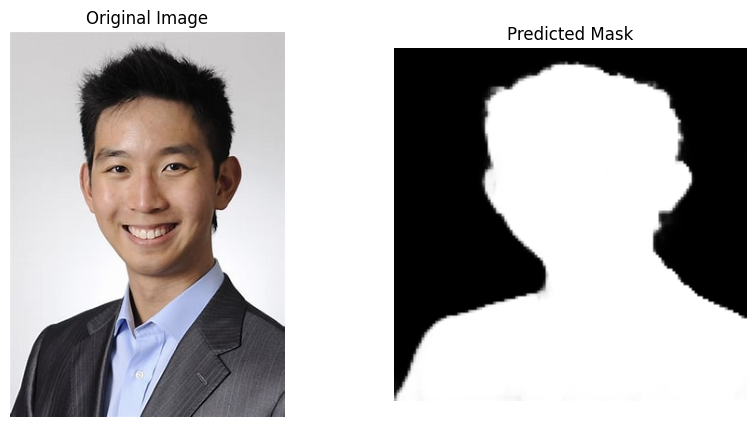

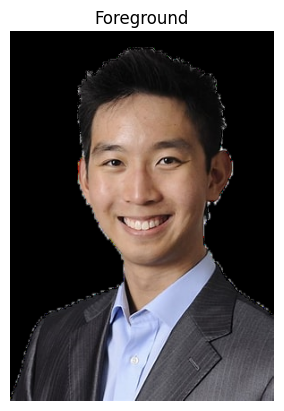

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

# Load the trained model
model = tf.keras.models.load_model('/content/unet_background_removal.keras')

# Load and preprocess the image
image_path = '/content/th.jpeg'
try:
    test_image = cv2.imread(image_path)
    test_image_resized = cv2.resize(test_image, (128, 128)) / 255.0
    test_image_resized = np.expand_dims(test_image_resized, axis=0)

    # Make a prediction
    predicted_mask = model.predict(test_image_resized)
    predicted_mask = np.squeeze(predicted_mask, axis=0)

    # Display the original image and the predicted mask
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')
    plt.show()

    # Apply the mask to the original image to remove the background
    # Convert the predicted mask to a binary mask
    binary_mask = (predicted_mask > 0.5).astype(np.uint8) * 255  # Threshold at 0.5

    # Ensure the image and mask have the same shape
    resized_binary_mask = cv2.resize(binary_mask, (test_image.shape[1], test_image.shape[0]))
    resized_binary_mask_3_channel = cv2.cvtColor(resized_binary_mask, cv2.COLOR_GRAY2BGR)

    foreground = cv2.bitwise_and(test_image, resized_binary_mask_3_channel)
    plt.imshow(cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB))
    plt.title("Foreground")
    plt.axis('off')
    plt.show()

except Exception as e:
    print(f"Error processing image: {e}")

In [ ]:
# prompt: save the model,numpy to background_removal_final folder in gdrive

import shutil

# Create the target directory if it doesn't exist
target_dir = '/content/drive/MyDrive/background_removal_final'
os.makedirs(target_dir, exist_ok=True)

# Move the model and numpy files to the target directory
shutil.move('/content/unet_background_removal.keras', target_dir)
shutil.move('/content/images.npy', target_dir)
shutil.move('/content/masks.npy', target_dir)

'/content/drive/MyDrive/background_removal_final/masks.npy'

In [ ]:
#####################################################################################

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Define ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    filepath='/content/unet_best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Define TensorBoard callback
log_dir = f"/content/logs/fit/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


# Train the model with callbacks
history = model.fit(
    images,
    masks,
    batch_size=16,
    epochs=20,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint, tensorboard_callback],
    verbose=1
)

# Save the final trained model
model.save('/content/unet_final_model.keras')
print("Model saved successfully.")


Epoch 1/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.7537 - loss: 0.5085
Epoch 1: val_loss improved from inf to 0.33741, saving model to /content/unet_best_model.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 111s 205ms/step - accuracy: 0.7538 - loss: 0.5082 - val_accuracy: 0.8576 - val_loss: 0.3374
Epoch 2/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8914 - loss: 0.2665
Epoch 2: val_loss improved from 0.33741 to 0.22297, saving model to /content/unet_best_model.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 76s 191ms/step - accuracy: 0.8915 - loss: 0.2664 - val_accuracy: 0.9105 - val_loss: 0.2230
Epoch 3/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9305 - loss: 0.1785
Epoch 3: val_loss improved from 0.22297 to 0.20400, saving model to /content/unet_best_model.keras
400/400 ━━━━━━━━━━━━━━━━━━━━ 79s 183ms/step - accuracy: 0.9305 - loss: 0.1785 - val_accuracy: 0.9198 - val_loss: 0.2040
Epoch 4/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9473 - loss: 0

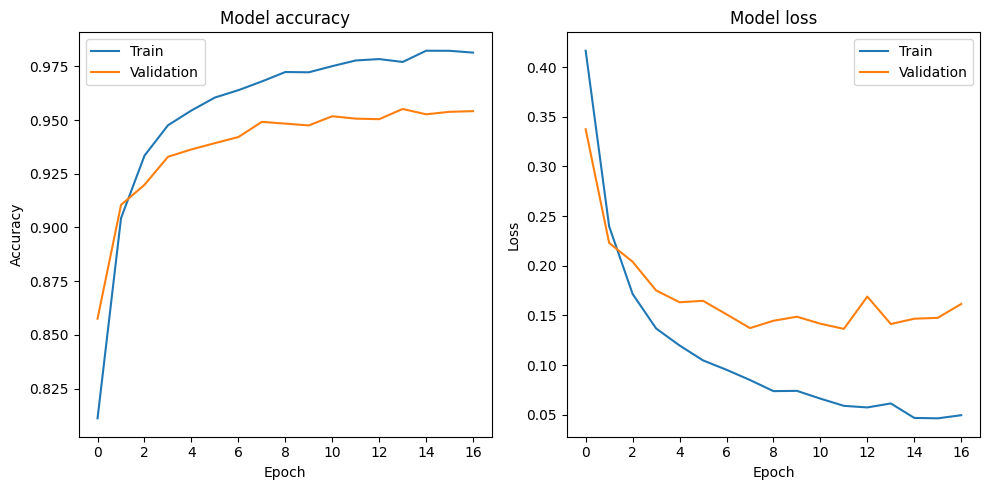

In [ ]:
# prompt: denerate  history plot
import matplotlib.pyplot as plt
# Plot training history
plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()